In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

import folium # map rendering library
import webbrowser
from bs4 import BeautifulSoup
import requests
import pgeocode
import unicodedata
print('Libraries imported.')

C:\Users\benno\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Libraries imported.


Vienna can be clustered into 23 districts. The first step in the analysis is to retrieve those districts from a 
gouvernment official website and load them into a pandas dataframe.

In [2]:
source = requests.get("https://www.vienna.at/features/bezirke-wien")
soup = BeautifulSoup(source.content,"html.parser")
data = soup.find_all("ul", {"id": "bezirke"})
lis = data[0].find_all('li')
for li in lis:
    newsoup = BeautifulSoup(str(li), 'html.parser')
table_bezirke = []
for li in lis:
    table_bezirke.append(li.text)

In [20]:
df = pd.DataFrame(table_bezirke)
df[0] = df[0].astype("string")    
df= df[0].str.split("\n",expand=True)
df.drop(columns = [0,4,5],inplace=True) 
df.head()

,1,2,3
0,1.,Innere Stadt,1010 Wien
1,2.,Leopoldstadt,1020 Wien
2,3.,Landstraße,1030 Wien
3,4.,Wieden,1040 Wien
4,5.,Margareten,1050 Wien


In [21]:
df.columns=["district_number","district_name","postalcode"]
df["postalcode"] = df["postalcode"].str.replace(" Wien","")
df["district_number"] = df["district_number"].str.replace(".","")
df.head()

,district_number,district_name,postalcode
0,1,Innere Stadt,1010
1,2,Leopoldstadt,1020
2,3,Landstraße,1030
3,4,Wieden,1040
4,5,Margareten,1050


Get the number of inhibitants from each district from a differnt table on the same webseite and merge the dataframes, this will later be used for bubble-plotting the map of vienna and examine neighborhoods with many people living there

In [24]:
lis = data[2].find_all('li')
for li in lis:
    newsoup = BeautifulSoup(str(li), 'html.parser')
table_people = []
for li in lis:
    table_people.append(li.text)
df_people = pd.DataFrame(table_people)
df_people[0] = df_people[0].astype("string")
df_people = df_people[0].str.split("\n",expand=True)
df_people.drop(columns = [0,4,5],inplace=True) 
df_people.columns=["district_number","district_name","people"]
df_people.drop(columns = ["district_number"],inplace=True) 
df_people.head()

,district_name,people
0,Innere Stadt,16.450
1,Leopoldstadt,105.574
2,Landstraße,90.712
3,Wieden,33.319
4,Margareten,55.640


Merge dfs on column "district_name" and convert "people" column to integer 

In [42]:
df_merged = pd.merge(df,df_people,on="district_name")
df_merged["people"] = df_merged["people"].str.replace(".","")
df_merged["people"] = df_merged["people"].astype("int")
df_merged.dtypes 

district_number    string
district_name      string
postalcode         string
people              int32
dtype: object

Get Latitude and Longitude Values by postal codes

In [43]:
df_merged["Latitude"]=""
df_merged["Longitude"]=""

nomi = pgeocode.Nominatim("at")

for pc in df_merged.postalcode:
    nomidata=nomi.query_postal_code(pc)
    lat=nomidata.latitude
    lng=nomidata.longitude
    df_merged.loc[df_merged["postalcode"]==pc,"Latitude"]  = lat
    df_merged.loc[df_merged["postalcode"]==pc,"Longitude"] = lng

address = 'Vienna'

geolocator = Nominatim(user_agent="vienna_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Vienna are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vienna are 48.2083537, 16.3725042.


In [27]:
map_vienna = folium.Map(location=[latitude,longitude],zoom_start=12)

for lat, lng, district,people in zip(df_merged['Latitude'], 
                                     df_merged['Longitude'], 
                                     df_merged['district_name'],
                                     df_merged['people']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    people = people/10000
    folium.CircleMarker(
        [lat, lng],
        radius=people,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vienna)
map_vienna    

So far so good - all 23 districts of vienna are displayed on the map with their respective number of inhabitants displayed by the bubble sizes. Now lets explore those neighborhoods by extracting venues from Foursquare

In [28]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180604'

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#function to extract venues in neighborhoods
LIMIT = 100
radius = 500
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

vienna_venues = getNearbyVenues(names=df_merged['district_name'],
                                latitudes=df_merged['Latitude'],
                                longitudes=df_merged['Longitude']) 

vienna_venues.head()

Innere Stadt
Leopoldstadt
Landstraße
Wieden
Margareten
Mariahilf
Neubau
Josefstadt
Alsergrund
Favoriten
Simmering
Meidling
Hietzing
Penzing
Rudolfsheim-Fünfhaus
Ottakring
Hernals
Währing
Döbling
Brigittenau
Floridsdorf
Donaustadt
Liesing


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Innere Stadt,48.2077,16.3705,Stephansplatz,48.208299,16.371880,Plaza
1,Innere Stadt,48.2077,16.3705,Stephansdom,48.208626,16.372672,Church
2,Innere Stadt,48.2077,16.3705,COS,48.209359,16.371591,Clothing Store
3,Innere Stadt,48.2077,16.3705,Graben,48.208915,16.369379,Pedestrian Plaza
4,Innere Stadt,48.2077,16.3705,DO & CO Restaurant,48.208240,16.371758,Restaurant


In [29]:
vienna_venues.groupby("Neighborhood").count()  
print('There are {} uniques categories.'.format(len(vienna_venues['Venue Category'].unique()))) 


There are 160 uniques categories.


Analyze each Neighborhood

In [30]:
# one hot encoding
vienna_onehot = pd.get_dummies(vienna_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vienna_onehot['Neighborhood'] = vienna_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [vienna_onehot.columns[-1]] + list(vienna_onehot.columns[:-1])
vienna_onehot = vienna_onehot[fixed_columns]

vienna_onehot.head() 

#%%Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
vienna_grouped = vienna_onehot.groupby("Neighborhood").mean().reset_index()
vienna_grouped.head()   

#Let's print each neighborhood along with the top 5 most common venue
num_top_venues = 5

for hood in vienna_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = vienna_grouped[vienna_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')    

----Alsergrund----
          venue  freq
0   Supermarket  0.10
1          Café  0.06
2  Tram Station  0.06
3     BBQ Joint  0.06
4   Beer Garden  0.03


----Brigittenau----
            venue  freq
0        Bus Stop  0.24
1           Plaza  0.14
2     Supermarket  0.10
3          Hostel  0.05
4  Cosmetics Shop  0.05


----Donaustadt----
               venue  freq
0        Supermarket  0.25
1     Hardware Store  0.25
2  Indian Restaurant  0.25
3         Restaurant  0.25
4              Motel  0.00


----Döbling----
                 venue  freq
0  Austrian Restaurant  0.27
1             Wine Bar  0.18
2           Restaurant  0.09
3                 Food  0.09
4                 Park  0.09


----Favoriten----
           venue  freq
0  Shopping Mall  0.17
1    Post Office  0.17
2  Metro Station  0.17
3     Smoke Shop  0.17
4  Grocery Store  0.17


----Floridsdorf----
            venue  freq
0     Supermarket   0.2
1  Discount Store   0.2
2        Vineyard   0.2
3      Restaurant   0.2
4   Shop

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#%% Display the top 10 venues in each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = vienna_grouped['Neighborhood']

for ind in np.arange(vienna_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vienna_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()  

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alsergrund,Supermarket,BBQ Joint,Tram Station,Café,Middle Eastern Restaurant,Food & Drink Shop,Cocktail Bar,Fried Chicken Joint,Beer Garden,Furniture / Home Store
1,Brigittenau,Bus Stop,Plaza,Supermarket,Bakery,Ice Cream Shop,Kebab Restaurant,Metro Station,Diner,Pharmacy,Cosmetics Shop
2,Donaustadt,Indian Restaurant,Hardware Store,Restaurant,Supermarket,Hostel,Food,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Service
3,Döbling,Austrian Restaurant,Wine Bar,Light Rail Station,Winery,Gastropub,Park,Food,Restaurant,Fast Food Restaurant,Farmers Market
4,Favoriten,Metro Station,Post Office,Smoke Shop,Park,Shopping Mall,Grocery Store,Yoga Studio,Eastern European Restaurant,Farmers Market,Falafel Restaurant


CLuster neighborhoods

In [32]:
#Run k-means to cluster the neighborhood into 5 clusters.
kclusters = 5

vienna_grouped_clustering = vienna_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vienna_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]   

array([1, 1, 0, 1, 1, 1, 1, 3, 1, 1])

In [46]:
df_merged.head()

,district_number,Neighborhood,postalcode,people,Latitude,Longitude
0,1,Innere Stadt,1010,16450,48.2077,16.3705
1,2,Leopoldstadt,1020,105574,48.2167,16.4
2,3,Landstraße,1030,90712,48.1981,16.3948
3,4,Wieden,1040,33319,48.192,16.3671
4,5,Margareten,1050,55640,48.1865,16.3549


In [47]:
neighborhoods_venues_sorted.head()

,Cluster_Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Alsergrund,Supermarket,BBQ Joint,Tram Station,Café,Middle Eastern Restaurant,Food & Drink Shop,Cocktail Bar,Fried Chicken Joint,Beer Garden,Furniture / Home Store
1,1,Brigittenau,Bus Stop,Plaza,Supermarket,Bakery,Ice Cream Shop,Kebab Restaurant,Metro Station,Diner,Pharmacy,Cosmetics Shop
2,0,Donaustadt,Indian Restaurant,Hardware Store,Restaurant,Supermarket,Hostel,Food,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Service
3,1,Döbling,Austrian Restaurant,Wine Bar,Light Rail Station,Winery,Gastropub,Park,Food,Restaurant,Fast Food Restaurant,Farmers Market
4,1,Favoriten,Metro Station,Post Office,Smoke Shop,Park,Shopping Mall,Grocery Store,Yoga Studio,Eastern European Restaurant,Farmers Market,Falafel Restaurant


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [45]:
df_merged.rename(columns={"district_name":"Neighborhood"},inplace=True)

In [48]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

df_merged=pd.merge(df_merged,neighborhoods_venues_sorted,on="Neighborhood")

#df_merged.drop("Cluster Labels",1,inplace=True)
df_merged.head()

,district_number,Neighborhood,postalcode,people,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Innere Stadt,1010,16450,48.2077,16.3705,1,Café,Italian Restaurant,Restaurant,Plaza,Austrian Restaurant,Cocktail Bar,Ice Cream Shop,Bakery,Bar,Hotel
1,2,Leopoldstadt,1020,105574,48.2167,16.4,1,Theme Park Ride / Attraction,Restaurant,Hotel,Café,Gastropub,Park,Fast Food Restaurant,Plaza,Beer Garden,Museum
2,3,Landstraße,1030,90712,48.1981,16.3948,1,Café,Hotel,Gourmet Shop,Italian Restaurant,Gastropub,Bakery,Bus Stop,Restaurant,Mediterranean Restaurant,Metro Station
3,4,Wieden,1040,33319,48.192,16.3671,1,Asian Restaurant,Restaurant,Café,Hotel,Austrian Restaurant,Pizza Place,Ice Cream Shop,Organic Grocery,Supermarket,Italian Restaurant
4,5,Margareten,1050,55640,48.1865,16.3549,1,Indian Restaurant,Austrian Restaurant,Italian Restaurant,Park,Supermarket,Bar,Hotel,Plaza,Vietnamese Restaurant,Pedestrian Plaza


Create the map

In [49]:
map_vienna_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], 
                                  df_merged['Longitude'], 
                                  df_merged['Neighborhood'], 
                                  df_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_vienna_clusters)
map_vienna_clusters    

# Supermarket analysis

Lets check out which districts have little or many places to buy food with respect to their inhabitantss
We will visualise the result and thereby identify possible districts where a new Supermarket opening
might benefit the neighborhood

In [50]:
market_df = vienna_grouped[["Neighborhood","Supermarket"]]
market_df.rename(columns={"Neighborhood":"district_name"},inplace=True)
market_df = pd.merge(market_df,df_people,on="district_name")
market_df["groceryStore"] = vienna_grouped["Grocery Store"]

C:\Users\benno\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Due to missing values in eighter of the two columns used, the combined grocery column will be built from the mean value
of the two columns or, in case of missing values, from the maximum value in eigher of the two columns "Supermarket" or "grocery store"

In [51]:
market_df["grocery_combined"] = np.maximum( (market_df["Supermarket"]+market_df["groceryStore"]) /2, market_df[["groceryStore","Supermarket"]].max(axis=1) )
market_df.head() 
market_df["people"] = market_df["people"].str.replace(".","")
market_df["people"] = market_df["people"].astype("int")
market_df["people_store_ratio"] = market_df["people"]*market_df["grocery_combined"]
market_df.head()

,district_name,Supermarket,people,groceryStore,grocery_combined,people_store_ratio
0,Alsergrund,0.096774,42547,0.000000,0.096774,4117.451613
1,Brigittenau,0.095238,87239,0.000000,0.095238,8308.476190
2,Donaustadt,0.250000,187007,0.000000,0.250000,46751.750000
3,Döbling,0.000000,72650,0.000000,0.000000,0.000000
4,Favoriten,0.000000,201882,0.166667,0.166667,33647.000000


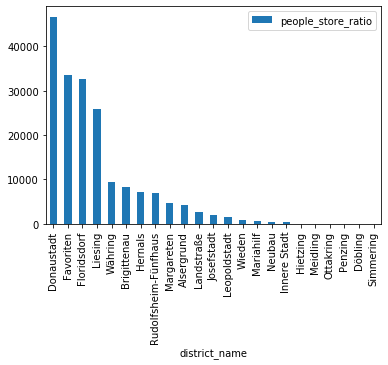

In [52]:
market_df.sort_values("people_store_ratio",inplace=True,ascending=False)
market_df.plot(x="district_name",y="people_store_ratio",kind="bar")

# Conclusion:

Ignoring the districts "Penzing","Hietzing","Meidling","Ottakring","Döbling" and "Simmering" due to missing values, the plot above shows districts' people-to-store ratio. The data suggests that there are a lot of grocerystores per innhabitant in "Liesing" and quite a few stores where you can buy food in "Innere Stadt". With a little bit of backgroud information about the city of vienna, that makes a lot of sense because "innere Stadt" beeing the very heart of Vienna has a lot of malls, bars, restaurant and other shops mainly focused od tourists. Districts with a low people-to-store ratio are districts where many people live and work thereby creating the need of grocery stores and supermarkets.